# Empowering Data Analysis through Visualization


GitHub repo: https://github.com/jbonfardeci/dl-covid19-kaggle

## Approach

With the amount of data available at our fingertips, cyphering though it all requires a significant amount time. At times this information is needed with the outmost importance to formulate a solution or complete a research.

By reviewing the original dataset, the team identified key elements that could assist in identifying the best possible results. Each of this elements have different level of weight that contribute to the relevance of the results. By identifying these metrics and their level of importance, data could be search with a weighted algorithm.

## K-Means Clustering
By using unsupervised learning ML technique of K-Means clustering, provided us methods for creating predictors to increase accuracy of our model.

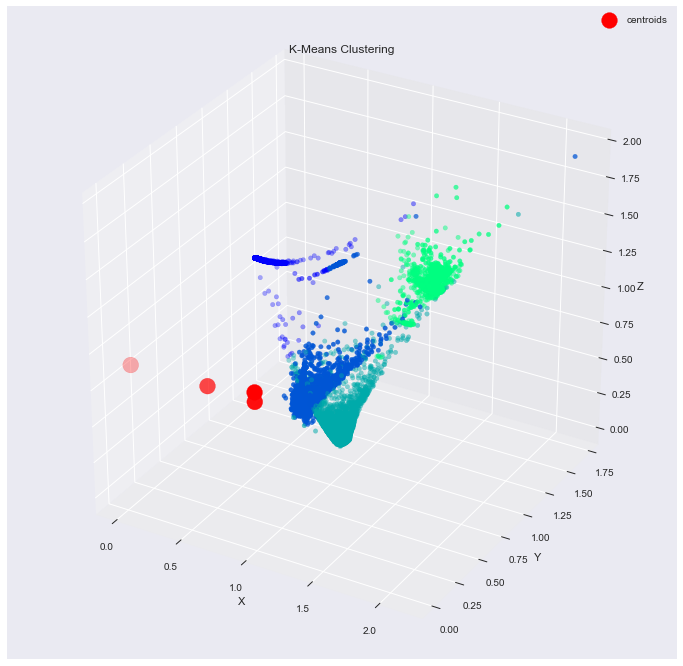![](http://)

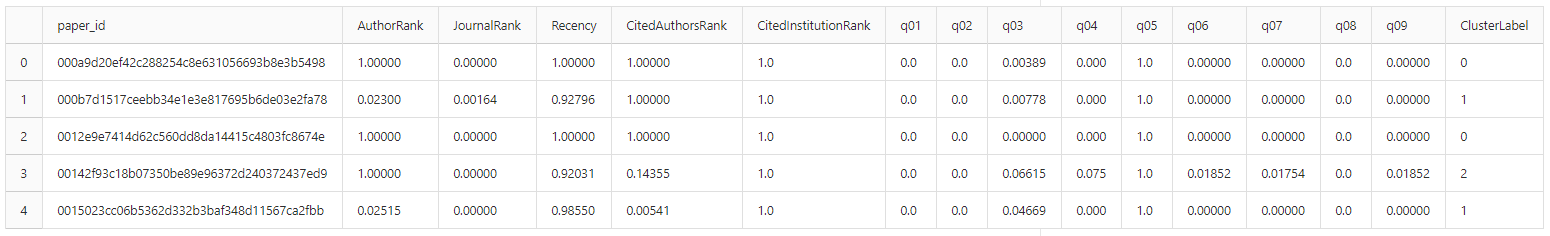

### Pros
* Empowers users to identify key elements and prioritize them for better result sets
* Provides a refinement approach by using cluster centers for modeling the data

### Cons
* The accuracy of the results is dependent on the quality of the intial dataset


## Data Visualization Tool

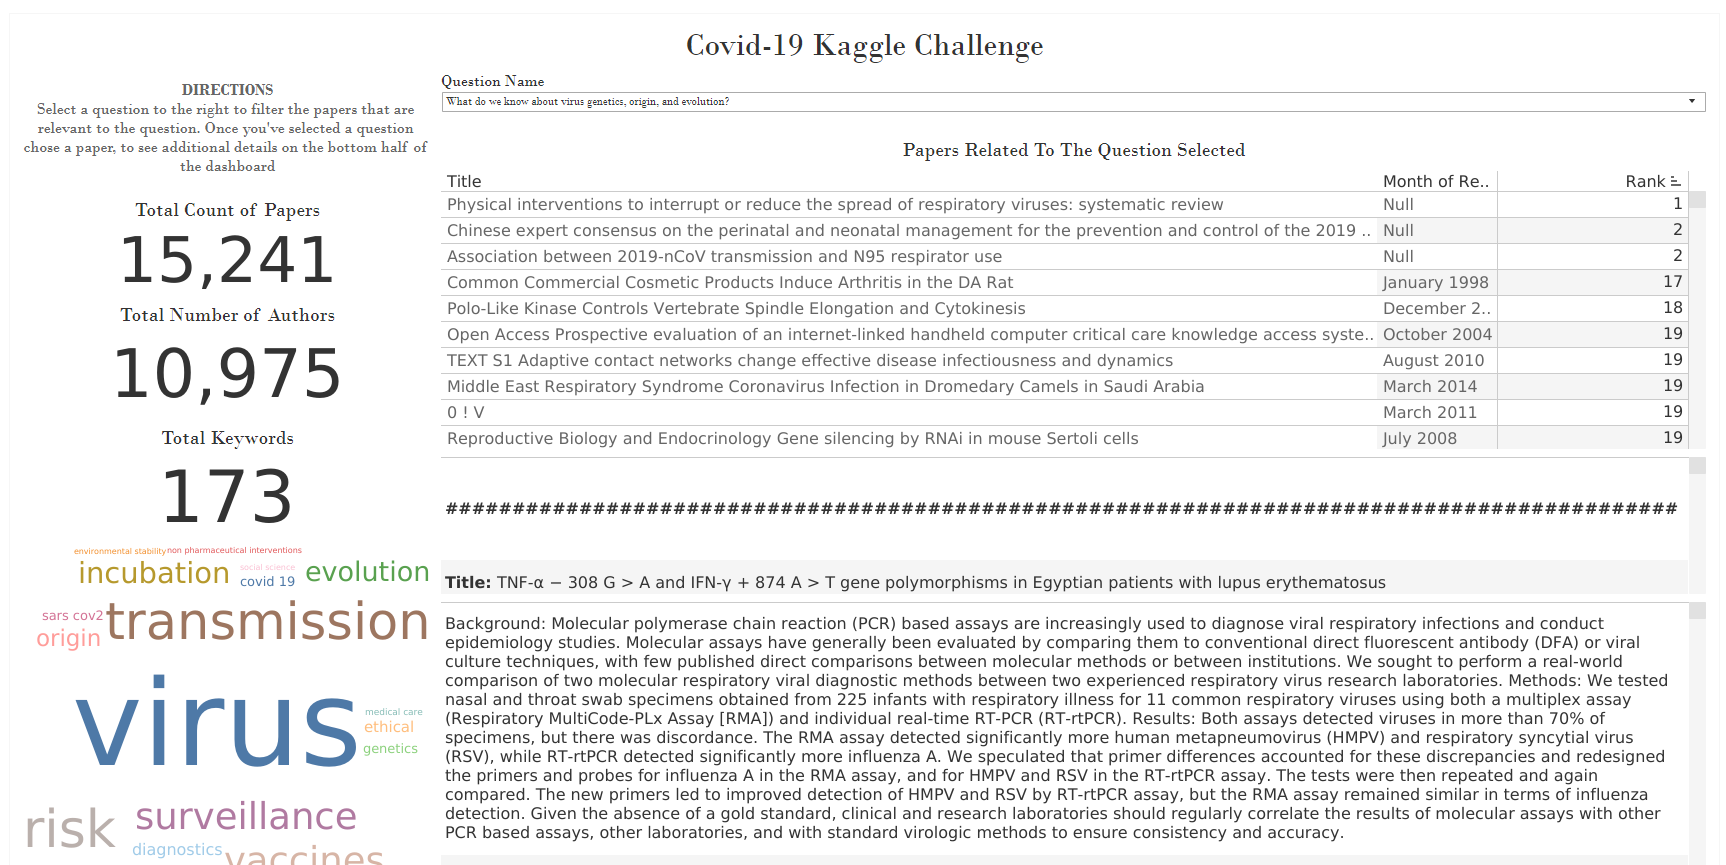
    
#### https://public.tableau.com/profile/james.eselgroth3249#!/vizhome/Covid19_15870982837470/Covid-19KaggleChallenge

# Import CSV and JSON Files to SQL Server

In [ ]:
# Utility Functions
def trim(s) -> str:
    if s == None:
        return s

    return re.sub(r'(^\s+|\s+$)', '', str(s))

def is_empty(s) -> bool:
    return s == None or trim(s) == '' 

def clean_str(s:str) -> str:
    if s == None or str(s) == 'nan':
        return None

    s = re.sub(r'[^a-zA-Z0-9\s.-_#:,]', '', str(s), re.DOTALL)
    return None if len(s) == 0 else s

def to_bool(s):
    rx = re.match("(1|true|yes)", trim(str(s).lower()), re.DOTALL)
    if rx:
        return rx.group() in ['1', 'yes', 'true']

    return False

def hash_author(author) -> str:

    def _in(prop:str, o) -> str:
        return trim(o[prop]) if prop in o else ''

    f = _in('first', author)
    l = _in('last', author)
    m = _in('middle', author)

    combined = str.format("{0}{1}{2}", f, l, m)
    hashed = hashlib.md5(combined.encode())
    return hashed.hexdigest()

def hash_strings(strings) -> str:
    a = [trim(s) for s in strings if not is_empty(s)]
    return hashlib.md5(''.join(a).encode()).hexdigest()

def is_iter(o):
    try:
        iter(o)
        return True
    except:
        return False

def to_bool(s):
    rx = re.match("^(1|true|yes)$", trim(str(s).lower()))
    if rx:
        return rx.group() in ['1', 'yes', 'true']

    return False

def clean_str(s):
    if s == None or str(s) == 'nan':
        return None

    s = re.sub( r'\n', ' ', str(s), re.DOTALL)
    s = re.sub( r'\r\n', ' ', s, re.DOTALL)
    s = re.sub( r'(^\'+|\'+$)', "", s, re.DOTALL)
    s = re.sub( r'\\+', "", s, re.DOTALL)
    s = re.sub( r'\'+', '\'\'', s, re.DOTALL)
    s = s.encode('ascii', 'ignore').decode()
    return None if len(s) == 0 else s

def to_int(s) -> int:
    try:
        n = int(is_dbnull(s))
        return n
    except:
        return None

def convert_to_json(contents):
    return json.loads(contents)

def read_json(path):
    infile = open(path, "r")
    return convert_to_json(infile.read())

def read_files(path):
    file_list = []
    for root, folders, docs in os.walk(path):
        file_list.extend( [os.path.join(root, doc) for doc in docs if '.json' in doc] )

    return file_list

def is_dbnull(s):
    if s == None:
        return 'NULL'

    return 'NULL' if clean_str(s) == None else str.format("'{0}'", clean_str(s))

## Import JSON files to SQL Server

In [ ]:
import json
import os
import re
import hashlib
import pyodbc 

"""
Import JSON articles into SQL Server
"""
# change to your params

ROOT = "/data/"
FOLDER = ROOT+"json/"

batch_info = {
    'commands': [],
    'paper_count': 0
}

def execute_batch(sql):
    commands = batch_info['commands']
    commands.append(sql)
    
    if len(commands) < 100:
        return
        
    print('Executing batch...')
    batch = ';\r\n'.join(commands)

    conn = pyodbc.connect('Driver={SQL Server};'
                          'Server=.\MSSQLSERVER19;'
                          'Database=covid19;'
                          'Trusted_Connection=yes;')
    
    cursor = conn.cursor()
    try:
        cursor.execute(batch)
        conn.commit()
    except:
        with open(ROOT+"sql_log.sql", "w") as f:
            f.writelines(batch)
            
        raise Exception("SQL syntax error. Exiting.")
        
    print('Batch executed.')
    print(str.format("Papers imported {0}", batch_info['paper_count']))
    commands.clear()
    
def insert_institution(affiliation):
    if 'laboratory' not in affiliation and 'institution' not in affiliation:
        return None

    laboratory = clean_str(affiliation['laboratory'])
    institution = clean_str(affiliation['institution'])

    if laboratory == None and institution == None:
        return None

    hash_id = hash_strings([institution, laboratory])
    addrLine = None
    postCode = None
    region = None
    country = None

    if 'location' in affiliation:
        loc = affiliation['location']
        addrLine = loc['addrLine'] if 'addrLine' in loc else None
        postCode = loc['postCode'] if 'postCode' in loc else None
        region = loc['region'] if 'region' in loc else None
        country = loc['country'] if 'country' in loc else None
    
    inst = {
        'hash_id': hash_id, 
        'institution_name': institution, 
        'laboratory': laboratory, 
        'addrLine': addrLine, 
        'postCode': postCode, 
        'region': region, 
        'country': country
    }
    
    o =  json.loads(json.dumps(inst), encoding='utf-8')
    
    s = """INSERT INTO import.Institution(hash_id, institution_name, laboratory, addrLine, 
            postCode, region, country) VALUES({0}, {1}, {2}, {3}, {4}, {5}, {6})"""
    
    sql = str.format(s, is_dbnull(o['hash_id']), is_dbnull(o['institution_name']), is_dbnull(o['laboratory']), \
            is_dbnull(o['addrLine']), is_dbnull(o['postCode']), is_dbnull(o['region']), is_dbnull(o['country']))
    
    execute_batch(sql)

    return hash_id

def insert_journal(name, issn):
    journal_name = clean_str(name)
    journal_issn = clean_str(issn)

    if journal_name == None and journal_issn == None:
        return

    hash_id = hash_strings([journal_name, journal_issn])
    
    journal = {
        'hash_id': hash_id, 
        'journal_name': journal_name, 
        'issn': journal_issn
    }
    
    o = json.loads(json.dumps(journal), encoding='utf-8')
    
    sql = str.format("INSERT INTO import.Journal(hash_id, journal_name, issn) VALUES({0}, {1}, {2})", \
        is_dbnull(o['hash_id']), is_dbnull(o['journal_name']), is_dbnull(o['issn']))
    
    execute_batch(sql)
   
    return hash_id

def insert_author(auth):
    hash_id = hash_author(auth)
    first = clean_str(auth['first']) if 'first' in auth else None  
    last = clean_str(auth['last']) if 'last' in auth else None
    suffix = clean_str(auth['suffix']) if 'suffix' in auth else None
    email = clean_str(auth['email']) if 'email' in auth else None  
    middle = None

    if 'middle' in auth and len(auth['middle']) > 0:
        middle = clean_str( ".".join( list( map(trim, auth['middle']) ) ) )
        
    author = {
        'hash_id': hash_id,
        'first_name': first,
        'last_name': last,
        'middle': middle,
        'suffix': suffix,
        'email': email
    }
    
    o = json.loads(json.dumps(author), encoding='utf-8')
    
    s = """INSERT INTO import.Author(hash_id,first_name,last_name,middle,suffix,email) 
            VALUES({0}, {1}, {2}, {3}, {4}, {5})"""
    sql =  str.format(s, is_dbnull(o['hash_id']), is_dbnull(o['first_name']), is_dbnull(o['last_name']), is_dbnull(o['middle']), \
                      is_dbnull(o['suffix']), is_dbnull(o['email']))   
    
    execute_batch(sql)
    
    return hash_id

def insert_affiliation(institution_hash, author_hash):
    if institution_hash == None or author_hash == None:
        return 

    sql = str.format("INSERT INTO import.Affiliation(institution_hash, author_hash) VALUES('{0}', '{1}')", \
                     institution_hash, author_hash) 
    
    execute_batch(sql)
    
def insert_citation(author_hash, paper_id):
    if paper_id == None:
        return 

    sql = str.format("INSERT INTO import.Citation(author_hash, paper_id) VALUES('{0}', '{1}')", author_hash, paper_id)
    
    execute_batch(sql)
    
def insert_authored(paper_id, author_hash):
    if paper_id == None or author_hash == None:
        return

    sql = str.format("INSERT INTO import.Authored(author_hash, paper_id) VALUES('{0}', '{1}')", author_hash, paper_id)
    
    execute_batch(sql)

def insert_publishedby(journal_hash, paper_id):
    if journal_hash == None or paper_id == None:
        return
        
    sql = str.format("INSERT INTO import.PublishedBy(journal_hash, paper_id) VALUES('{0}', '{1}')", \
                     journal_hash, paper_id)
    
    execute_batch(sql)
    
def insert_paper(json_paper):
    paper_id = json_paper['paper_id']
    metadata = json_paper['metadata']
    authors = metadata['authors']
    bib_entries = json_paper['bib_entries']
    title = clean_str(metadata['title'])
    body_text = None
    abstract = None
    abstract_nodes = []
    text_nodes = []

    # Combine all sections in abstract array
    for ab in json_paper['abstract']:
        s = clean_str(ab['text'])
        if s != None:
            abstract_nodes.append(s)

    if len(abstract_nodes) > 0:
        abstract = " ".join(abstract_nodes)

    # Combine all sections in body_text array    
    for section in json_paper['body_text']:
        s = clean_str(section['text'])
        if s != None:
            text_nodes.append(s)

    if len(text_nodes) > 0:
        body_text = " ".join(text_nodes)
        
    paper = {
        'paper_id': paper_id,
        'title': title,
        'abstract': abstract,
        'body_text': body_text
    }
    
    obj = json.loads(json.dumps(paper), encoding='utf-8')
    body = json.dumps(obj['body_text'], ensure_ascii=True)
    abst = json.dumps(obj['abstract'], ensure_ascii=True)
    body = body.replace("'", "")
    abst = abst.replace("'", "")
    
    sql = str.format("INSERT INTO import.Paper(paper_id, title, abstract, body_text) VALUES({0}, {1}, {2}, {3})", \
       is_dbnull(paper_id), is_dbnull(obj['title']), is_dbnull(abst), is_dbnull(body))
    
    execute_batch(sql)
    batch_info['paper_count'] += 1
    

    for author in authors:
        author_hash = insert_author(author)
        insert_authored(paper_id, author_hash)

        if 'affiliation' in author:
            inst_hash = insert_institution(author['affiliation'])
            insert_affiliation(inst_hash, author_hash)

    for bibref in bib_entries:
        bib = bib_entries[bibref]
        journal_hash = insert_journal(bib['venue'], bib['issn'])
        insert_publishedby(journal_hash, paper_id)

        for author in bib['authors']:
            author_hash = insert_author(author)
            insert_citation(author_hash, paper_id)

    return paper_id


def insert_sql():
    json_papers = read_files(FOLDER)
    i = 0
    for path in json_papers:
        #print(path)
        json_paper = read_json(path)
        insert_paper(json_paper)
        i += 1
        print(i)

# Uncomment to run
# insert_sql()

In [ ]:
import re
import json
import pandas as pd
import hashlib

def authors_to_list(paper_id:str, s:str):
    """
    Parse the different list types of authors in CSV data.
    """
    s = str(s)

    def strip_quotes(s):
        return trim(re.sub(r'\"', '', s, re.DOTALL))

    def _to_dict(s):
        if s == None:
            return {} 

        auth = {
            "paper_id": paper_id,
            "hash_id": None,
            "first": None,
            "last": None,
            "middle": None
        }

        if s.find(',') > -1:
            names = list( map(strip_quotes, s.split(',')) )
            first = re.sub(r'[^a-zA-Z\s\-]', '', names[1], re.DOTALL)
            tmp = first.split(' ')
            if len(tmp) > 1:
                auth['middle'] = tmp.pop()
                first = trim(' '.join(tmp))

            auth['first'] = first
            auth['last'] = names[0]

        else:
            auth['last'] = strip_quotes(s)

        auth['hash_id'] = hash_author(auth)
        return auth

    if s == None or len(trim(s)) == 0:
        return []

    s = re.sub(r'\',\s\'', ';', s, re.DOTALL) 
    s = re.sub(r'[^a-z0-9A-Z\-,\s\;]', '', s, re.DOTALL)         
    lst = list(map(_to_dict, s.split(';')))

    return lst


def import_csv_metadata():
    file_path = "../data/all_sources_metadata_2020-03-13_clean.csv"
    df = pd.read_csv(file_path)
    authors = df[['sha', 'authors', 'has_full_text']].values.tolist()
    
    data = []

    i = 0
    for row in authors:
        if to_bool(row[2]) and str(row[1]) != 'nan':
            paper_id = str.format('na_paper_id_{0}', i) if str(row[0]) == 'nan' else row[0]
            lst = authors_to_list(paper_id, row[1])
            data.extend(lst)
        
        i += 1

    
    author_df = pd.DataFrame(columns=['paper_id', 'hash_id', 'first', 'last', 'middle'], data=data)
    author_df.to_csv("../data/authors.csv")

# Uncomment to run
# import_csv_metadata()


# K-Means Clustering

We will use the unsupervised learning ML technique of K-Means clustering, where we seek to identity primary groups of papers where their cluster is unknown. K-Means also provides us a method for *feature engineering* where it's desirable to create more predictors to increase accuracy of our model.

In [ ]:
# Import libraries
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline
import pandas as pd
import math
import seaborn as sns

In [ ]:
# Change data_dir to folder on your computer.
data_dir = "../data/"
filepath = data_dir+"paper_ranks.csv"
num_clusters = 9
text_columns = ['paper_id'] # 
numeric_columns = ['AuthorRank', 'JournalRank', 'Recency', 'CitedAuthorsRank', 'CitedInstitutionRank', \
                   'q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'q08', 'q09']
model_data = None
logical_cores = 4 # how many logical CPU cores you have

In [ ]:
# Functions
def normalize(df):
    """
    Normalize and Scale the numerical columns
    """
    data = df.copy().values   
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_data = min_max_scaler.fit_transform(data)
    return pd.DataFrame(columns=df.columns, data=scaled_data)

def plot_scree(percent_variance):
    """
    Create Scree Plot of Principal Components Variance
    """  
    # Visualize the variance explained for each observation by the principal components
    cols = []
    for i in range(len(percent_variance)):
        cols.append('PC'+str(i+1))

    sns.barplot(y=cols, x=percent_variance)
    plt.title('PCA Scree Plot - larger explains more variance')
    plt.show()

In [ ]:
# Import XDF Online Retail data set
df = pd.read_csv(filepath)
df = df.drop('q10', 1)
df = df.fillna(1)
df.head()

In [ ]:
df.describe()

In [ ]:
model_df = df.copy().drop('paper_id', 1)
# Normalize data
model_df = normalize(model_df)
model_df.head()

In [ ]:
# Use visual diagnostic to estimate optimal number of clusters
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(model_df)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 10), wcss)
plt.title('Optimal #Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

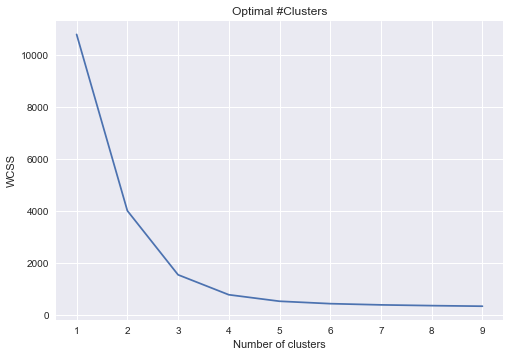

In [ ]:
num_clusters = 4

In [ ]:
km = KMeans(n_clusters=num_clusters, 
            random_state=123, 
            verbose=True, 
            n_jobs=logical_cores, 
            algorithm='full')

kmeans_data = km.fit_transform(model_df)
clusters = km.predict(model_df)
labels = km.labels_

In [ ]:
# Create dataframe for our PC variables.
k_columns = []
for i in range(len(kmeans_data[0])):
    k_columns.append('PC'+str(i+1))
    
kmeans_df = pd.DataFrame(columns=k_columns, data=kmeans_data)
kmeans_df.head()

In [ ]:
#Plot the clusters obtained using k means
# https://thatascience.com/learn-machine-learning/kmeans/
fig = plt.figure(1, figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot Cluster Centroids
scatter = ax.scatter(km.cluster_centers_[:, 0], # get 1st N of each row
                     km.cluster_centers_[:, 1],
                     km.cluster_centers_[:, 2],
                     s = 250, 
                     marker='o', 
                     c='red', 
                     label='centroids')

# Plot Cluster X, Y, Z points
scatter = ax.scatter(kmeans_data[:, 0], 
                     kmeans_data[:, 1], 
                     kmeans_data[:, 2],
                     c=clusters, 
                     s=20, 
                     cmap='winter')

ax.set_title('K-Means Clustering')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()


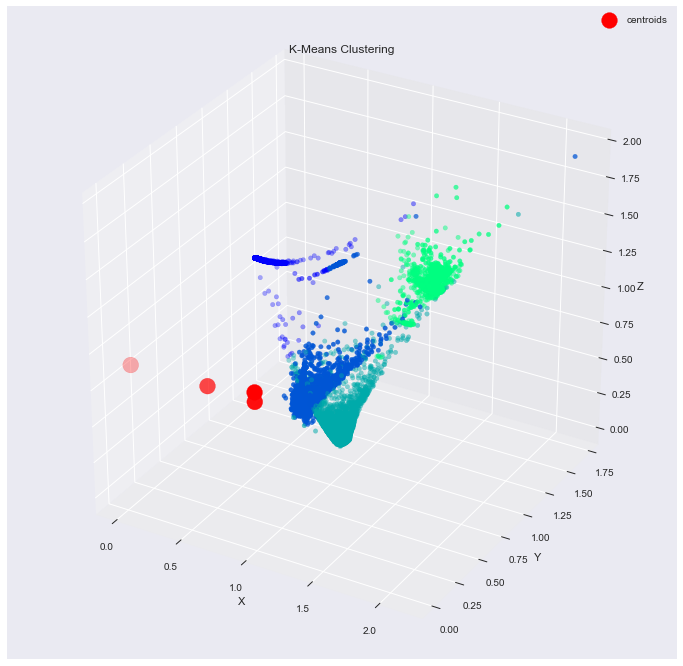

In [ ]:
paper_id = df['paper_id'].values
data = list( zip(paper_id, clusters) )
labeld_df = pd.DataFrame(columns=['paper_id', 'cluster'], data=data)
df['ClusterLabel'] = clusters
labeld_df.head()

In [ ]:
labeld_df.to_csv(data_dir+"paper_kmeans_clusters.csv")

In [ ]:
df.head()